# Autonomous Driving - Automatic detection of vehicles on the road for vehicle tracking, vehicle counting, and road incident response

<span style='color:Purple; font-size:20px'> **Description of the Problem Statement** - Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time is essential for vehicle tracking, vehicle counting, and road incident response </span>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import cv2

<span style='color:blue; font-size:20px'> **Part-1 : Task** -As the first part of this project, you need to develop an AI model using a deep learning framework that predicts the type of vehicle present in an image as well as localizes the vehicle by rectangular bounding box. </span>

<span style='color:Green; font-size:18px'> **Part-1 : Concept of problem statement** - Object detection is a computer vision technique that identifies and locates objects within an image or video. Object detection provides the class and bounding box coordinates of each detected object </span>

<span style='color:Purple; font-size:18px'> **Task** - Constants used in implementing CNN for Object Detection - Model is inspired by YOLO (You Only Look Once) architecture, design and implementation</span>

In [2]:
# Constants for Object Detection
IMG_SIZE_1 = 144
GRID_SIZE_1 = 9
CELL_SIZE_1 = IMG_SIZE_1 // GRID_SIZE_1
NUM_CLASSES = 10

<span style="font-size:16px; color:red"> **Inferences** - The architecture of this CNN for multiple object detection in an image is inspired by YOLO model  </span>

<span style='color:Purple; font-size:18px'> **Task** - Display some images from the dataset for Object Detection </span>

In [3]:
# Get all image files
images_files = []
for file in os.listdir('Images'):
    if file.endswith(('.jpg', '.png')):
        images_files.append(file)   

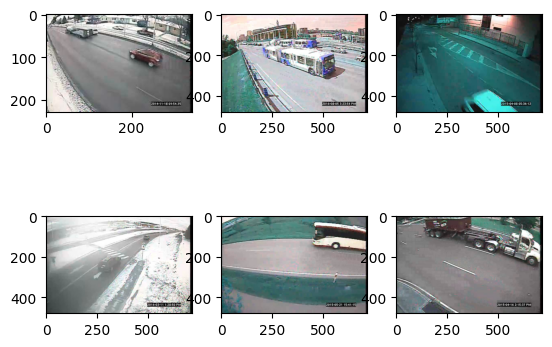

In [4]:
# Load and view images from the dataset
dataset = []
for count in range(6):
    ax = plt.subplot(2, 3, count+1)
    path = "Images/" + images_files[count]
    image = cv2.imread(path)
    dataset.append(image)
    plt.imshow(image)

<span style="font-size:16px; color:red"> **Inferences** - Understanding the image dataset by reading all file names in the 'Images' directory and displaying some of the sample images using cv2 library </span>

<span style='color:Purple; font-size:18px'> **Task** - Load labels for images in dataset for Object Detection </span>

In [5]:
label_dataframe = pd.read_csv("labels_new.csv")
label_dataframe.head()

,image_id,class_name,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


In [6]:
# Map class names to IDs
class_map = {idx: name for idx, name in enumerate(label_dataframe['class_name'].unique())}
print(class_map)

{0: 'pickup_truck', 1: 'car', 2: 'articulated_truck', 3: 'bus', 4: 'motorized_vehicle', 5: 'work_van', 6: 'single_unit_truck', 7: 'pedestrian', 8: 'bicycle', 9: 'non-motorized_vehicle', 10: 'motorcycle'}


<span style="font-size:16px; color:red"> **Inferences** 
- Label processing has been completed in the other Jupyter Notebook code file submitted with project where excel file is read and grouped by image ID and split into individual label files corresponding to the images
- Unique Class names are named to the Class IDs
</span>

<span style='color:Purple; font-size:18px'> **Task** - Preparation of train/validation dataset for the Object Detection </span>

In [7]:
SPLIT_RATIO = 0.8  # 80% train, 20% validation

In [8]:
split_index = int(len(images_files) * SPLIT_RATIO)
split_index

4500

In [9]:
split_data = {
    "train": images_files[:split_index],
    "val": images_files[split_index:]
}

In [10]:
train_data_images = len(split_data['train'])
print(train_data_images)

4500


In [11]:
# Get all label files in the train
label_train_files = []
for file in os.listdir('dataset/labels/train'):
    if file.endswith('.txt'):
        label_train_files.append(file)    

In [12]:
len(label_train_files)

4500

In [13]:
# Get all label files for validation
label_val_files = []
for file in os.listdir('dataset/labels/val'):
    if file.endswith('.txt'):
        label_val_files.append(file)    

In [14]:
len(label_val_files)

1126

<span style="font-size:16px; color:red"> **Inferences** - Splitting the dataset into train and validation and reading corresponding files names from the train and validation images and label directories </span>

<span style='color:Purple; font-size:18px'> **Task** - Pre-process images for the Object Detection </span>

In [15]:
# Function to preprocess the image
def preprocess_image(image_path):    
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image from BGR to RGB (as YOLOv5 uses RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to 640x640 (YOLOv5 expects a 640x640 input)
    img_resized = cv2.resize(img, (144, 144))

    # Normalization of pixel valoes between 0-1
    img_resized = img_resized/255.0

    return img_resized

<span style="font-size:16px; color:red"> **Inferences** - Pre-processing image to make it compatible with the CNN architecture. Using OpenCV2 reads an image, converting it to RGB, resizing to 144 pixels, normalizing it between 0-1. Image size is set to 144x144 pixels instead of high resolution 640x640 due to constraint on memory and execution capability of laptop required for training models with high resolution </span>

<span style='color:Purple; font-size:18px'> **Task** - Pre-process train images and write corresponding labels in an array for the Object Detection </span>

In [16]:
train_img_resized = []
train_label_target = []
max_boxes = 25

for i in range(train_data_images):
    image_path = "dataset/images/train/" + split_data['train'][i]
    train_img_resized.append(preprocess_image(image_path))
    label_path =  "dataset/labels/train/" + label_train_files[i]
    #print(label_path)
    #boxes = []
    boxes = np.zeros((max_boxes, 5))
    counter = 0
    with open(label_path) as f:
        for line in f.readlines():
            cls_id, x, y, w, h = map(float, line.strip().split())
            #boxes.append([x, y, w, h, int(cls_id)])
            boxes[counter] = [int(cls_id), x, y, w, h]
            counter = counter + 1
    train_label_target.append(boxes)

In [17]:
print(train_img_resized[0].shape)
print(len(train_img_resized))
print(len(train_label_target))
print(train_label_target[0])

(144, 144, 3)
4500
4500
[[0.       0.365625 0.0875   0.065625 0.033333]
 [1.       0.364844 0.208333 0.123438 0.091667]
 [1.       0.264062 0.064583 0.04375  0.016667]
 [2.       0.11875  0.083333 0.103125 0.0625  ]
 [1.       0.179688 0.080208 0.028125 0.027083]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.   

<span style="font-size:16px; color:red"> **Inferences** - The train images are processed and added to the list and correcponding label files are read and added to the 'boxes' array of size 25x5. After 'boxes' are created for a label file it is added to the list  </span>

<span style='color:Purple; font-size:18px'> **Task** - Pre-process validation images and write corresponding labels in an array for the Object Detection </span>

In [18]:
val_data_images = len(split_data['val'])
print(val_data_images)

1126


In [19]:
val_img_resized = []
val_label_target = []
max_boxes = 25

for i in range(val_data_images):
    image_path = "dataset/images/val/" + split_data['val'][i]
    val_img_resized.append(preprocess_image(image_path))
    label_path =  "dataset/labels/val/" + label_val_files[i]
    #boxes = []
    boxes = np.zeros((max_boxes, 5))
    counter = 0
    with open(label_path) as f:
        for line in f.readlines():
            if counter < 25:
                cls_id, x, y, w, h = map(float, line.strip().split())
                #boxes.append([x, y, w, h, int(cls_id)])
                boxes[counter] = [cls_id, x, y, w, h]
                counter = counter + 1
    val_label_target.append(boxes)

In [20]:
print(val_img_resized[0].shape)
print(len(val_img_resized))
print(len(val_label_target))
print(val_label_target[0].shape)

(144, 144, 3)
1126
1126
(25, 5)


<span style="font-size:16px; color:red"> **Inferences** - The validation images are processed and added to the list and correcponding label files are read and added to the 'boxes' array of size 25x5. After 'boxes' are created for a label file it is added to the list  </span>

<span style='color:Purple; font-size:18px'> **Task** - Arranging labels in a particular format expected by the CNN model inspired by YOLO during training the model </span>

In [21]:
def convert_to_yolo_grid_format(labels, grid_size=9, num_classes=10, anchors_per_cell=1):
    """
    Convert label array of shape (batch, max_boxes, 5) to YOLO grid format:
    Output: (batch, grid_size, grid_size, anchors_per_cell * (5 + num_classes))
    """
    batch_size = labels.shape[0]
    max_boxes = labels.shape[1]
    grid_labels = np.zeros((batch_size, grid_size, grid_size, anchors_per_cell * (5 + num_classes)))
   
    for b in range(batch_size):
        for box in labels[b]:
            #print(box)
            class_id, x, y, w, h = box
            #print(f"x = {x}, y = {y}, w = {w}, h = {h}, class = {class_id}")
            if w == 0 or h == 0:
                continue  # skip padding boxes if any

            # Determine which grid cell the center of the box falls into
            grid_x = int(x * grid_size)
            grid_y = int(y * grid_size)

            if grid_y >= grid_size or grid_x >= grid_size:
                continue  # skip invalid boxes
                
            x_cell = (x * grid_size) - grid_x
            y_cell = (y * grid_size) - grid_y

            # YOLO-style encoding: [x, y, w, h, objectness, class_one_hot...]
            # x, y, w, h remain normalized (relative to image)
            objectness = 1.0
            class_one_hot = np.zeros(num_classes)
            class_id = int(class_id)
            if class_id < num_classes:
                class_one_hot[class_id] = 1

            # Fill the anchor slot (assuming B=1)
            #grid_labels[b, grid_y, grid_x, 0:4] = [x, y, w, h]
            grid_labels[b, grid_y, grid_x, 0:4] = [x_cell, y_cell, w, h]
            grid_labels[b, grid_y, grid_x, 4] = objectness
            grid_labels[b, grid_y, grid_x, 5:] = class_one_hot

    return grid_labels

In [22]:
num_classes = 10  # Set according to your dataset
train_label_grid = convert_to_yolo_grid_format(np.array(train_label_target), grid_size=9, num_classes=num_classes)

<span style="font-size:16px; color:red"> **Inferences** - The label data points are arranged in a particular format to be processed by the YOLO like CNN model, where x_cell, y_cell, width, height, objectness, one hot encoding for the class is written in an order </span>

<span style='color:Purple; font-size:18px'> **Task** - View the objectness of the object present in a particular image as described by the corresponding label file</span>

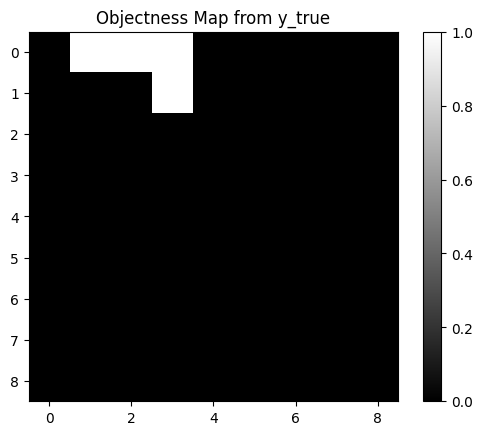

In [23]:
#Visualize Objectness Mask
objectness_mask = train_label_grid[0][..., 4]  # shape: (GRID_SIZE, GRID_SIZE)
plt.imshow(objectness_mask, cmap='gray')
plt.title("Objectness Map from y_true")
plt.colorbar()
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - The objectness data point in the labels encodeding suggest if the object is present in the image. It is plotted to showcase that label encoding is correct and indicates the presence of object in an image  </span>

<span style='color:Purple; font-size:18px'> **Task** - Verification of the label encoding by viewing the image with  bounding boxes around the objects present in an image</span>

In [24]:
# Decode and Plot Bounding Boxes from y_true
def decode_y_true_to_boxes(y_true, grid_size, img_size):
    boxes = []
    cell_size = img_size / grid_size
    for row in range(grid_size):
        for col in range(grid_size):
            data = y_true[row, col]
            #print(data)
            obj = data[4]
            if obj > 0.5:
                x_cell, y_cell, w, h = data[0], data[1], data[2], data[3]
                x_center = (col + x_cell) * cell_size
                y_center = (row + y_cell) * cell_size
                x1 = int(x_center - w * img_size / 2)
                y1 = int(y_center - h * img_size / 2)
                x2 = int(x_center + w * img_size / 2)
                y2 = int(y_center + h * img_size / 2)
                boxes.append((x1, y1, x2, y2))
    return boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


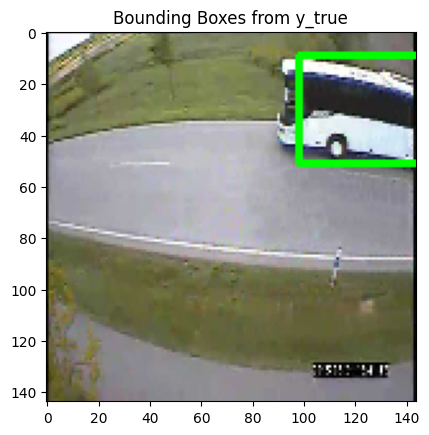

In [25]:
y_true = train_label_grid
tmp_path = 'dataset/images/train/00000004.jpg'
image1 = preprocess_image(tmp_path)
boxes = decode_y_true_to_boxes(y_true[4], GRID_SIZE_1, IMG_SIZE_1)
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(image1, (x1, y1), (x2, y2), (0,255,0), 2)

plt.imshow(image1)
plt.title("Bounding Boxes from y_true")
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - The above step is to do verification of the label encoding by drawing the bounding boxes based on the provided labels of the image  </span>

<span style='color:Purple; font-size:18px'> **Task** - Designing CNN Architecture with multiple Convolutional layers
- CNN inspired by YOLO is a real-time object detection algorithm that treats object detection as a regression problem.
- A single neural network predicts bounding boxes and class probabilities from full images.
- The image is divided into an S × S grid. Each grid cell predicts: B bounding boxes (coordinates + confidence scores) and C class probabilities
</span>

In [26]:
def build_yolo_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE_1, IMG_SIZE_1, 3)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(GRID_SIZE_1 * GRID_SIZE_1 * (5 + NUM_CLASSES)),
        layers.Reshape((GRID_SIZE_1, GRID_SIZE_1, 5 + NUM_CLASSES))
    ])
    return model
    

In [27]:
model = build_yolo_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 144, 144, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 72, 72, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1215)                │         623,295 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 9, 9, 15)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,029,663 (23.00 MB)

 Trainable params: 6,029,663 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

<span style="font-size:16px; color:red"> **Inferences** - CNN Model with various Convolution layers for the Feature extraction and Max Pooling layer for the down sampling is used for the object detection </span>

<span style='color:Purple; font-size:18px'> **Task** - Custom loss functions for the CNN model </span>

In [28]:
def custom_yolo_loss_v1(y_true, y_pred):
    obj_mask = tf.expand_dims(y_true[..., 4], axis=-1)  # 1 where object present, else 0
    noobj_mask = 1.0 - obj_mask

    # Bounding Box Loss — only for cells with objects
    bbox_loss = tf.reduce_mean(obj_mask * tf.square(y_true[..., 0:4] - y_pred[..., 0:4]))

    # Objectness Loss — two parts: object & no-object
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true[..., 4], logits=y_pred[..., 4])
    obj_loss = tf.reduce_mean(obj_mask[..., 0] * obj_loss + 0.5 * noobj_mask[..., 0] * obj_loss)  # down-weight background

    # Class Loss — only for cells with objects
    class_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[..., 5:], logits=y_pred[..., 5:])
    class_loss = tf.reduce_mean(obj_mask[..., 0] * class_loss)

    total_loss = bbox_loss + obj_loss + class_loss
    return total_loss
    

In [29]:
train_img_array = np.array(train_img_resized)

In [30]:
train_label_array = np.array(train_label_target)

In [31]:
train_label_array.shape

(4500, 25, 5)

In [32]:
print("YOLO labels shape:", train_label_grid.shape)
print("Model output shape:", model.output_shape)

YOLO labels shape: (4500, 9, 9, 15)
Model output shape: (None, 9, 9, 15)


<span style="font-size:16px; color:red"> **Inferences** - Custom loss function is written for the CNN Model for the object detection to account for the following losses - [1] Bounding boxes [2.] Objectness Loss [3.] Class Loss</span>

<span style='color:Purple; font-size:18px'> **Task** - Training the CNN model defined for the multiple object detection in an image</span>

In [33]:
model.compile(optimizer='adam', loss=custom_yolo_loss_v1, metrics=['accuracy'])
history = model.fit(train_img_array, train_label_grid, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.0554 - loss: 0.1892 - val_accuracy: 0.0513 - val_loss: 0.1402
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.0588 - loss: 0.1314 - val_accuracy: 0.0721 - val_loss: 0.1101
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.0849 - loss: 0.1008 - val_accuracy: 0.1411 - val_loss: 0.0987
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.1429 - loss: 0.0812 - val_accuracy: 0.1683 - val_loss: 0.0922
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.1659 - loss: 0.0670 - val_accuracy: 0.1875 - val_loss: 0.0941
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.1822 - loss: 0.0558 - val_accuracy: 0.1907 - val_loss: 0.0906
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.1816 - loss: 0.0457 - val_accuracy: 0.1913 - val_loss: 0.0935
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.1905 - loss: 0

<span style="font-size:16px; color:red"> **Inferences** - CNN Model for the object detection is trained with the pre-processed images and the corresponding encoded labels</span>

<span style='color:Purple; font-size:18px'> **Task** - Viewing the performance metrics of the trained CNN model for the Object Detection</span>

In [34]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [35]:
# Plotting Training vs Validation Metrics

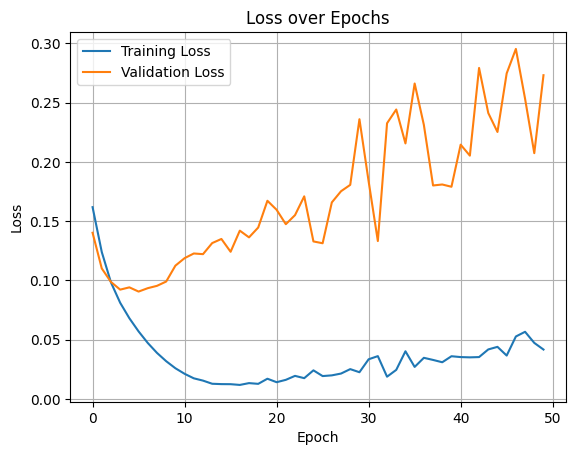

In [36]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

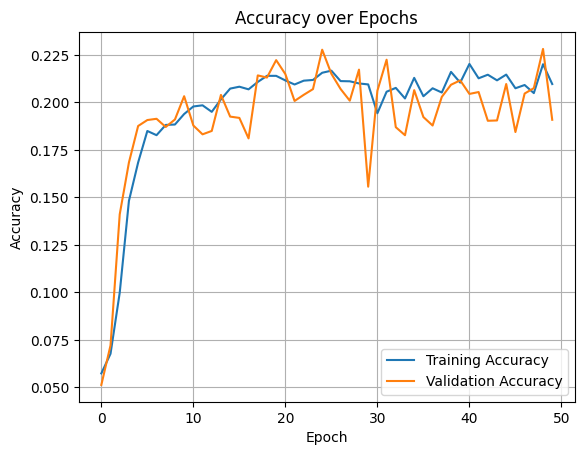

In [37]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - Plotted training versus validation LOSS and training versus validation ACCURACY</span>

<span style='color:Purple; font-size:18px'> **Task** - Validation of the model for viewing the performance metrics of the trained CNN model for the Object Detection</span>

In [38]:
def decode_predictions(pred, grid_size=9, num_boxes=1, num_classes=10, conf_threshold=0.5):
    boxes = []
    cell_size = 1.0 / grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            cell = pred[i, j]
            for b in range(num_boxes):
                base = b * 5
                x, y, w, h, conf = cell[base:base+5]
                if conf > conf_threshold:
                    cx = (j + x) * cell_size
                    cy = (i + y) * cell_size
                    class_probs = cell[num_boxes * 5:]
                    class_id = np.argmax(class_probs)
                    boxes.append((cx, cy, w, h, conf, class_id))
    return boxes

In [39]:
def decode_ground_truth(gt, grid_size=9, num_boxes=1, num_classes=10):
    boxes = []
    cell_size = 1.0 / grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            cell = gt[i, j]
            for b in range(num_boxes):
                base = b * 5
                x, y, w, h, conf = cell[base:base+5]
                if conf > 0.5:
                    cx = (j + x) * cell_size
                    cy = (i + y) * cell_size
                    class_probs = cell[num_boxes * 5:]
                    class_id = np.argmax(class_probs)
                    boxes.append((cx, cy, w, h, conf, class_id))
    return boxes

In [40]:
def evaluate_single_image(pred_boxes, gt_boxes, iou_threshold=0.5):
    matched_gt = set()
    tp = 0
    fp = 0

    for pb in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for idx, gb in enumerate(gt_boxes):
            if gb[-1] != pb[-1] or idx in matched_gt:
                continue
            iou = compute_iou(pb[:4], gb[:4])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        if best_iou >= iou_threshold:
            tp += 1
            matched_gt.add(best_gt_idx)
        else:
            fp += 1

    fn = len(gt_boxes) - len(matched_gt)
    return tp, fp, fn

In [41]:
def compute_iou(box1, box2):
    def to_corners(box):
        cx, cy, w, h = box
        return [cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2]

    x1_min, y1_min, x1_max, y1_max = to_corners(box1)
    x2_min, y2_min, x2_max, y2_max = to_corners(box2)

    xi1 = max(x1_min, x2_min)
    yi1 = max(y1_min, y2_min)
    xi2 = min(x1_max, x2_max)
    yi2 = min(y1_max, y2_max)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

In [42]:
def evaluate_model(y_pred, y_val):
    total_tp, total_fp, total_fn = 0, 0, 0

    for i in range(len(y_pred)):
        pred_boxes = decode_predictions(y_pred[i])
        gt_boxes = decode_ground_truth(y_val[i])
        tp, fp, fn = evaluate_single_image(pred_boxes, gt_boxes)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1_score

In [43]:
num_classes = 10  # Set according to your dataset
val_label_grid = convert_to_yolo_grid_format(np.array(val_label_target), grid_size=9, num_classes=num_classes)

In [44]:
# Validate model performance on validation set
val_img_array = np.array(val_img_resized)
print(val_img_array.shape)
y_predict = model.predict(val_img_array)

(1126, 144, 144, 3)
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [45]:
precision, recall, f1 = evaluate_model(y_predict, val_label_grid)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 0.0062, Recall: 0.0056, F1 Score: 0.0059


<span style="font-size:16px; color:red"> **Inferences** - Performance metrics is obtained - Precision, Recall and F1 Score. The model is trained for Epochs = 50 due to memory and execution constraint of the system  </span>

In [46]:
def visualize_image(image, boxes):
    h, w, _ = image.shape
    image = image.copy()
    for (cx, cy, bw, bh, conf, class_id) in boxes:
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{class_map[int(class_id)]} ({conf:.2f})", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


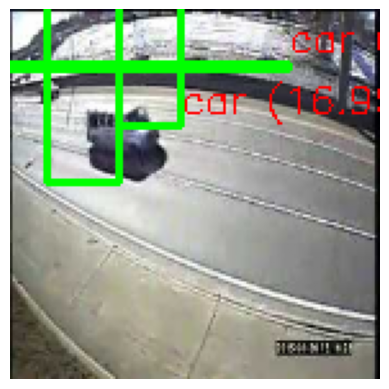

In [47]:
img = visualize_image(val_img_array[0], decode_predictions(y_predict[0]))
plt.imshow(img)
plt.axis("off")
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - Validation image is predicted using CNN object detection model with required bounding boxes and classification  </span>

<span style='color:Purple; font-size:18px'> **Task** - Testing the model on images for object detection with bounding boxes and classification</span>

In [48]:
def draw_yolo_boxes(image, output, conf_threshold=0.5):
    grid_size = output.shape[0]  # 9
    cell_size = image.shape[0] // grid_size  # assuming square image
    boxes = []
    CLASS_NAMES = {
        0: "pickup_truck",
        1: "car",
        2: "articulated_truck",
        3: "bus",
        4: "motorized_vehicle",
        5: "work_van",
        6: "single_unit_truck",
        7: "pedestrian",
        8: "bicycle",
        9: "non-motorized_vehicle",
        10: "motorcycle"
    }
    for i in range(grid_size):
        for j in range(grid_size):
            cell = output[i, j]  # shape: (5 + NUM_CLASSES)
            x, y, w, h = cell[0:4]
            #print(x, y, w, h)
            obj_score = cell[4]
            #print(obj_score)
            if obj_score < conf_threshold:
                continue

            # Class prediction
            #class_probs = cell[5:]
            class_probs = tf.nn.softmax(cell[5:]).numpy()
            class_id = np.argmax(class_probs)
            class_name = CLASS_NAMES.get(class_id, "unknown")
            class_score = class_probs[class_id]

            # Convert to global image coordinates
            cx = (j + x) * cell_size  # grid x
            cy = (i + y) * cell_size  # grid y
            bw = w * image.shape[1]
            bh = h * image.shape[0]

            x1 = int(cx - bw / 2)
            y1 = int(cy - bh / 2)
            x2 = int(cx + bw / 2)
            y2 = int(cy + bh / 2)

            #boxes.append((x1, y1, x2, y2, class_id, obj_score * class_score))
            boxes.append((x1, y1, x2, y2, class_name, obj_score * class_score))

    return boxes

In [49]:
def visualize_boxes(image, boxes, class_names=None):
    image = image.copy()
    for (x1, y1, x2, y2, cls_id, score) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_names[cls_id] if class_names else cls_id}: {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return image

In [50]:
# 00000010.jpg,  00000020.jpg, 00000030.jpg, 00000050.jpg
train_source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\train\\00000160.jpg'
#train_source = 'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1\\dataset\\images\\test\\00004640.jpg'

# Read the image using OpenCV
test_image1 = cv2.imread(train_source)

# Convert the image from BGR to RGB (as YOLOv5 uses RGB)
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)

# Resize the image to 144x144 (YOLOv5 expects a 640x640 input)
test_image1_resized = cv2.resize(test_image1, (144, 144))

test_image1_resized = test_image1_resized/255.0

test_input_1 = np.expand_dims(test_image1_resized, axis=0).astype(np.float32)

print(test_input_1.shape)
#predict_and_plot(model, test_image1_resized)

print(type(test_input_1))
output = model.predict(test_input_1)[0]


(1, 144, 144, 3)
<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [51]:
print(test_input_1.shape)
print(np.min(test_input_1), np.max(test_input_1))

(1, 144, 144, 3)
0.0 1.0


In [52]:
print(output.shape)

(9, 9, 15)


[(35, 37, 64, 12, 'car', np.float32(13.186434)), (31, 19, 89, 38, 'car', np.float32(2.7270715)), (187, 188, -25, -75, 'car', np.float32(8.257595)), (53, 138, 180, 89, 'car', np.float32(4.7088265)), (27, 190, 38, 40, 'car', np.float32(8.6965))]


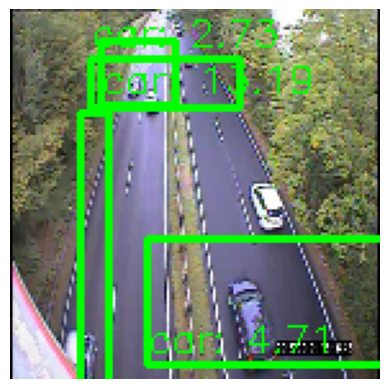

In [53]:
image = test_input_1[0]  # original input image

#boxes = draw_yolo_boxes(image, output, conf_threshold=0.5)
boxes = draw_yolo_boxes(image, output, conf_threshold=0.1)
print(boxes)
image_with_boxes = visualize_boxes((image * 255).astype(np.uint8), boxes, class_names=None)

plt.imshow(image_with_boxes)
plt.savefig('TestResult_20')
plt.axis('off')
plt.show()

<span style="font-size:16px; color:red"> **Inferences** - Test images shows the required bounding boxes with the classification of vehicles in an image. Screen print of the test images is attached with the project </span>